[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juanchess98/Notebooks-Deep-Learning/blob/transfer_learning/transfer_learning.ipynb)

# Transfer Learning (Enfoque por cuadrantes o escenarios usando Pytorch)

Aprender una tarea nueva puede ser un proceso que lleve una considerable cantidad de tiempo. Sin embargo, los seres humanos tienen la capacidad de asociar nuevas tareas con otras que ya sabe como ejecutar y aplicar este conocimiento para reducir el tiempo y costo de aprendizaje. Por ejemplo, si una persona sabe como manejar una bicicleta, para esa persona será mucho más fácil aprender a manejar una motocicleta. Asimismo, una persona que domine el idioma español tendrá mucha más facilidad para aprender otro idioma similar, como el portugués, que una persona de origen alemán o japonés.

Este mismo concepto se puede aplicar a las máquinas inteligentes y se le conoce como *Transfer Learning* o Aprendizaje por transferencia. En este caso, un modelo desarrollado para una resolver una tarea puede usarse como punto de partida para resolver otra tarea similar.

Pueden presentarse diferentes escenarios en la aplicación de *transferencia de aprendizaje* a un dataset nuevo, pero generalmente se puede reducir a cuatro casos:

1. La nueva base de datos es numerosa y se parece muy poco a la base de datos del modelo pre-entrenado
2. La nueva base de datos es numerosa y parecida a la base de datos del modelo pre-entrenado
3. La nueva base de datos es pequeña y diferente de la base de datos del modelo pre-entrenado
4. La nueva base de datos es pequeña y parecida a la base de datos del modelo pre-entrenado

En la siguiente gráfica tipo plano cartesiano pueden visualizarce mejor los posibles escenarios, dividiendo el plano en cuadrantes que representan cada escenario y dónde en la dirección de crecimiento del eje $x$ se indica la similaridad de los dos datasets y el eje $y$ el tamaño del nuevo dataset.

**(Insertar imagen de cuadrantes aquí)**

Para cada escenario existe una metodología diferente a implementar y en el curso de este notebook trataremos de ejemplificar cada una con la ayuda de los frameworks de Keras y Pytorch.

Como primer paso se cargan las librerías a usar en nuestros ejemplos:

In [29]:
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms

## Caso 1. La nueva base de datos es numerosa y diferente a la del modelo pre-entrenado

Si la nueva base de datos es grande y no se parece a la original, se recomienda seguir los siguientes pasos:

1. Quitar la última capa totalmente conectada y añadir una nueva capa totalmente conectada cuya dimensión de salida se igual al número de clases de la nueva base de datos.

2. Aleatorizar los pesos de la nueva capa totalmente conectada e inicializarlos con valores aleatorios

3. Entrenar la red para actualizar los pesos de la nueva capa totalmente conectada.


### Cargar la base de datos similar

En este ejemplo se usará CIFAR10 como nueva base de datos similar a la base de datos del modelo pre-entrenado (Imagenet). CIFAR10 está conformada por imágenes de dimensión 3x32x32, es decir, 3 canales y resolución 32x32 píxeles. Asimismo, cuenta con 10 clases que son:  ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

En el siguiente bloque se muestra el procedimiento para cargar la base de datos CIFAR10 usando el paquete Torchvision de PyTorch que incluye dataloaders para algunas de las bases de datos más comunes en visión por computadora.

In [41]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


En la siguiente función está nuestro modelo de entrenamiento

In [52]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders = trainloader
                '''for inputs, labels in trainloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)'''
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = testloader
                '''for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)'''

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Visualización de imágenes del nuevo dataset

La siguiente función la usamos para ver algunas de las imágenes de la nueva base de datos CIFAR10 y se imprime su respectiva etiqueta.

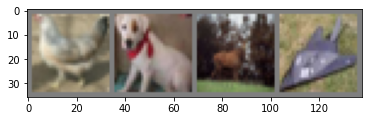

 bird   dog  deer plane


In [43]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Cargar el modelo preentrenado

In [44]:
from torchvision import datasets, models, transforms

In [45]:
pretrained_model = models.vgg16(pretrained=False)

## Caso 4. La nueva base de datos es pequeña y similar a la original

Si la nueva base de datos es pequeña y se parece a la base de datos del modelo preentrenado, los pasos son los siguientes:

1. Quitar la última capa totalmente conectada de la red neuronal.
2. Añadir una nueva capa totalmente conectada que tenga como dimensiones de salida el número de clases del nuevo dataset.
3. Aleatorizar los pesos de la nueva capa totalmente conectada.
4. Congelar todos los pesos de la red pre-entrenada.
5. Entrenar la red para actualizar los pesos de la nueva capa totalmente conectada.

#### Paso 1. 

Se carga el modelo de la red VGG16 pre-entrenado con ImageNet al hacer $pretrained=True$. Nótese que las dimensiones de la última capa de salida son (4096, 1000), donde 1000 es el número de clases de la base de datos Imagenet.

In [46]:
pretrained_model = models.vgg16(pretrained=True)
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Siguiendo los pasos 1 y 2, quitamos la última capa totalmente conectada y se reemplaza por una capa nueva con dimensiones de salida (4096, 10), donde 10 es el número de clases de CIFAR10.

In [47]:
criterion = nn.CrossEntropyLoss()
pretrained_model.classifier[6]= nn.Linear(4096, 10)

In [48]:
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

### Paso 4.

Se congelan todos los pesos de la red pre-entrenada con $requires_grad = False$, esto impide que se calculen los gradientes en back-propagation.

In [49]:
for param in pretrained_model.parameters():
    param.requires_grad = False

### Paso 5. 

Se entrena el modelo

In [50]:
optimizer_conv = optim.SGD(pretrained_model.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [53]:
model_conv = train_model(pretrained_model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 